In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)

import scipy.io as sio
import h5py
import os

import nibabel as nb
import numpy as np

from niio import loaded

from scipy.spatial.distance import pdist,cdist
from sklearn import covariance, preprocessing

from scipy.stats import beta, chi2, gamma, f, probplot, norm

In [2]:
ddir = '/Users/kristianeschenburg/Desktop/Research/Data/'
cortdir = '{:}CorticalRegionalization/Destrieux/'.format(ddir)


#strt = '{:}285345.L.Cortical.Regionalized.MMP.mat'.format(cortdir)
strt = '{:}ProbTrackX2/285345.L.Cortical.Regionalized.noAdj.ProbTrackX2.LogTransformed.Single.aparc.a2009s.mat'.format(cortdir)
rest = '{:}RestingState/285345.L.Cortical.Regionalized.RestingState.aparc.a2009s.mat'.format(cortdir)

In [3]:
labfile = '{:}Labels/HCP/285345.L.CorticalAreas.fixed.32k_fs_LR.label.gii'.format(ddir)

In [4]:
label = nb.load(labfile)
label = label.darrays[0].data

In [5]:
S = loaded.load(strt).T

bind = list(np.where(np.abs(S).sum(0) == 0)[0])
indices = np.asarray(list(set(np.arange(S.shape[1])).difference({bind[0]})))
S = S[:,indices]

SN = preprocessing.normalize(S)

R = loaded.load(rest).T
bind = list(np.where(np.abs(R).sum(0) == 0)[0])

indices = np.asarray(list(set(np.arange(R.shape[1])).difference({bind[0]})))
R = R[:,indices]
RN = preprocessing.normalize(R)


/Users/kristianeschenburg/anaconda3/lib/python3.6/site-packages/sklearn/utils/extmath.py:71: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(norms, norms)


In [7]:
[u,s,v] = np.linalg.svd(SN, full_matrices=False)

In [9]:
u3 = u[:,0:3]

In [11]:
u3n = preprocessing.normalize(u3,axis=1)

/Users/kristianeschenburg/anaconda3/lib/python3.6/site-packages/sklearn/utils/extmath.py:71: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(norms, norms)


In [17]:
import seaborn as sns

In [43]:
# Unique category labels: 'D', 'F', 'G', ...
color_labels = np.unique(label)

# List of RGB triplets
rgb_values = sns.color_palette("Paired", len(np.unique(label)))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

point_colors = [color_map[k] for k in label]

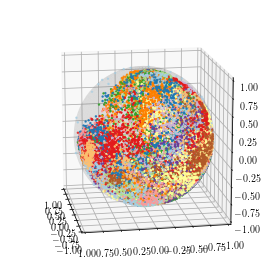

In [44]:
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

#Set colours and render
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(
    x, y, z,  rstride=1, cstride=1, color='gray', alpha=0.1, linewidth=0)
ax.view_init(15, 170)

ax.scatter(u3n[:,0],u3n[:,1],u3n[:,2], color=point_colors, s=2)

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

In [6]:
labels = np.unique(label)[1:]
label_map = {L: np.where(label == L)[0] for L in labels}

In [566]:
GData = np.row_stack([SN[label_map[8],:]])

non_g = [label_map[k] for k in label_map.keys() if k != 8]
non_g = np.concatenate(non_g)
SData = np.row_stack([SN[non_g,:]])

EG = covariance.ShrunkCovariance(assume_centered=False, shrinkage=0.2)
EG.fit(GData)

cEG = EG.covariance_
pEG = EG.precision_

In [567]:
d1 = cdist(SData, GData.mean(0)[None,:], metric='mahalanobis', VI=pEG)
d2 = cdist(GData, GData.mean(0)[None,:], metric='mahalanobis', VI=pEG)

In [568]:
D1 = d1**2
D2 = d2**2

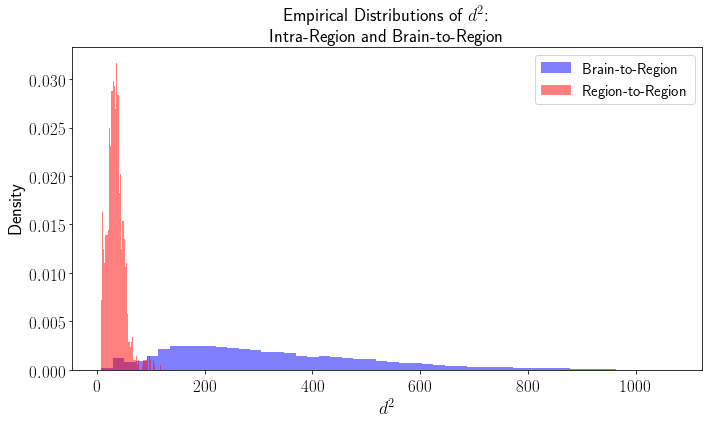

In [784]:
fig = plt.figure(figsize=(10,6))
plt.hist(D1, 50, density=True, alpha=0.5, color='blue', label = 'Brain-to-Region');
plt.hist(D2, 50, density=True, alpha=0.5, color='red', label = 'Region-to-Region');
plt.legend(fontsize=15);
plt.title('Empirical Distributions of $d^2$: \n Intra-Region and Brain-to-Region',fontsize=18);
plt.xlabel('$d^{2}$',fontsize=18);
plt.xticks(fontsize=17);
plt.ylabel('Density',fontsize=18);
plt.yticks(fontsize=17);
plt.tight_layout();
plt.savefig('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/SquaredMahalanobisDistributions.png')

In [570]:
# Beta MLE on External
mle_beta = beta.fit(D1)
beta_pdf = beta.pdf(np.linspace(np.min(D1), np.max(D1), 1000), *mle_beta)

/Users/kristianeschenburg/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


In [571]:
# F MLE on External
mle_f = f.fit(D1)
f_pdf = f.pdf(np.linspace(np.min(D1), np.max(D1), 1000), *mle_f)

/Users/kristianeschenburg/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [572]:
# Chi2 MLE on Source
mle_chi2 = chi2.fit(D2)
chi2_pdf = chi2.pdf(np.linspace(np.min(D2), np.max(D2), 1000), *mle_chi2)

In [573]:
# Beta MLE on Source
mle_beta_true = beta.fit(D2)
beta_pdf_true = beta.pdf(np.linspace(np.min(D2), np.max(D2), 1000), *mle_beta_true)

/Users/kristianeschenburg/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0.5,1,'Fitted Beta Distribution')

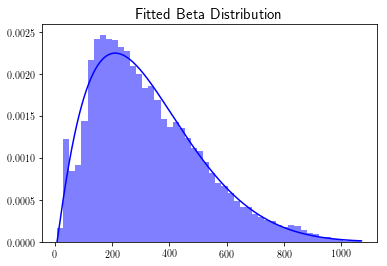

In [574]:
plt.hist(D1, 50, density=True, color='blue', alpha=0.5);
plt.plot(np.linspace(np.min(D1), np.max(D1), 1000), beta_pdf, color='blue')
plt.title('Fitted Beta Distribution',fontsize=15)

Text(0.5,1,'Fitted F Distribution')

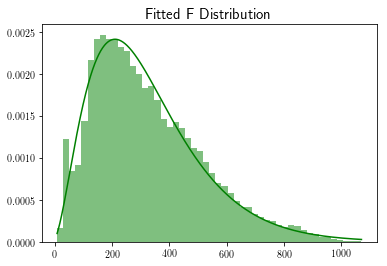

In [575]:
plt.hist(D1, 50, density=True, color='green', alpha=0.5);
plt.plot(np.linspace(np.min(D1), np.max(D1), 1000), f_pdf, color='green')
plt.title('Fitted F Distribution', fontsize=15)

Text(0.5,1,'Source: Fitted Chi2 Distribution')

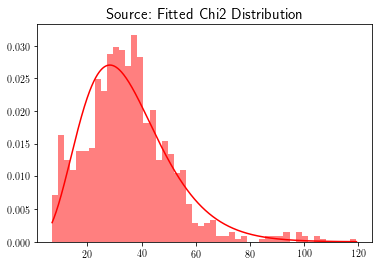

In [576]:
plt.hist(D2, 50, density=True, color='red', alpha=0.5);
plt.plot(np.linspace(np.min(D2), np.max(D2), 1000), chi2_pdf, color='red')
plt.title('Source: Fitted Chi2 Distribution', fontsize=15)

Text(0.5,1,'Source: Fitted Beta Distribution')

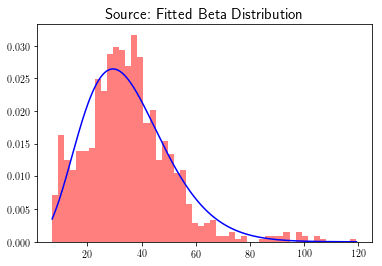

In [577]:
plt.hist(D2, 50, density=True, color='red', alpha=0.5);
plt.plot(np.linspace(np.min(D2), np.max(D2), 1000), beta_pdf_true, color='blue')
plt.title('Source: Fitted Beta Distribution', fontsize=15)

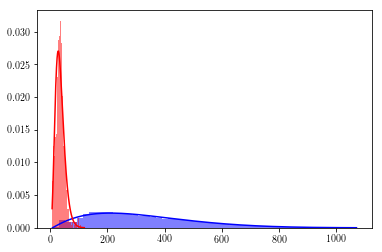

In [578]:
plt.hist(D1, 50, density=True, alpha=0.5, color='blue');
plt.plot(np.linspace(np.min(D1),np.max(D1),1000),beta_pdf, color='blue')

plt.hist(D2, 50, density=True, alpha=0.5, color='red');
plt.plot(np.linspace(np.min(D2),np.max(D2),1000), chi2_pdf, color='red')

In [622]:
a = 74/2
b = (len(d1)-74-1)/2
mle_beta_theory = beta.fit(D1, a, b)

a = 74
b = len(d1)-a - 1
mle_f_theory = f.fit(D1, a, b)


a = SN.shape[1]
mle_chi2_theory = chi2.fit(D2,a)

/Users/kristianeschenburg/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/kristianeschenburg/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [580]:
beta_pdf_theory = beta.pdf(np.linspace(np.min(D1),np.max(D1),1000), *mle_beta_theory)
f_pdf_theory = f.pdf(np.linspace(np.min(D1),np.max(D1),1000), *mle_f_theory)

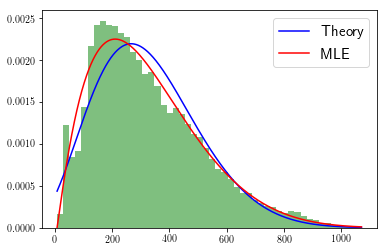

In [581]:
plt.hist(D1, 50, density=True, alpha=0.5, color='green');
plt.plot(np.linspace(np.min(D1),np.max(D1),1000), beta_pdf_theory, color='blue', label = 'Theory')
plt.plot(np.linspace(np.min(D1),np.max(D1),1000), beta_pdf, color='red', label = 'MLE')
plt.legend(fontsize=15)

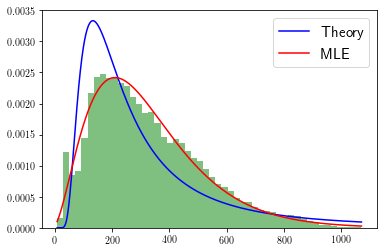

In [582]:
plt.hist(D1, 50, density=True, alpha=0.5, color='green');
plt.plot(np.linspace(np.min(D1),np.max(D1),1000), f_pdf_theory, color='blue', label = 'Theory')
plt.plot(np.linspace(np.min(D1),np.max(D1),1000), f_pdf, color='red', label = 'MLE')
plt.legend(fontsize=15)


In [583]:
p = 74

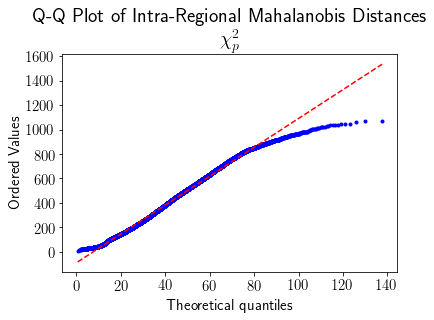

In [672]:
fig = plt.figure()
ax = fig.add_subplot(111)

probplot(D1.squeeze(), (mle_chi2), dist=chi2, plot=plt);
p_title = 'Q-Q Plot of Intra-Regional Mahalanobis Distances \n $\chi^{2}_{p}$'
plt.title(p_title, fontsize=20)
ax.get_lines()[0].set_marker('.')

ax.get_lines()[1].set_linestyle('--')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)

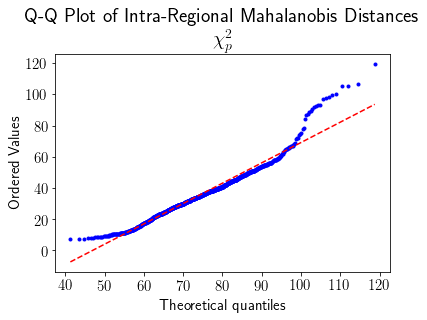

In [584]:
fig = plt.figure()
ax = fig.add_subplot(111)

probplot(D2.squeeze(), (p), dist=chi2, plot=plt);
p_title = 'Q-Q Plot of Intra-Regional Mahalanobis Distances \n $\chi^{2}_{p}$'
plt.title(p_title, fontsize=20)
ax.get_lines()[0].set_marker('.')

ax.get_lines()[1].set_linestyle('--')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)


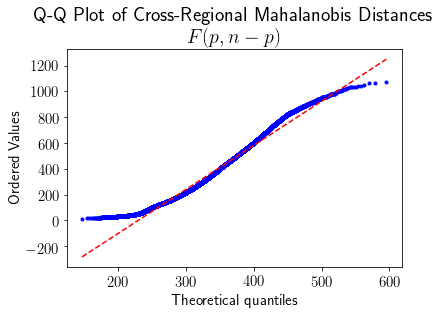

In [585]:
a = p
b = len(D1)-a

fig = plt.figure()
ax = fig.add_subplot(111)

probplot(D1.squeeze(), (a,b, *mle_f[2:]), dist=f, plot=plt,);
plt.title('Q-Q Plot of Cross-Regional Mahalanobis Distances \n $F(p, n-p)$', fontsize=20);

ax.get_lines()[0].set_marker('.')
ax.get_lines()[1].set_linestyle('--')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)


In [608]:
from niio import write

z = np.zeros((32492,1))
z[non_g[np.where(cdatas>p_val)[0]]] = np.log(cdatas[np.where(cdatas>p_val)[0]])

y = np.zeros((32492,1))
y[label_map[8]] = 8

mh2 = np.zeros((32492,))
mh2[non_g] = D1.squeeze()

write.save(z,'/Users/kristianeschenburg/Desktop/PVal.func.gii','CortexLeft')
write.save(y,'/Users/kristianeschenburg/Desktop/Region8.func.gii','CortexLeft')
write.save(mh2,'/Users/kristianeschenburg/Desktop/Mahal.Squared.func.gii','CortexLeft')


In [ ]:
xr = np.linspace(D2.min(), D2.max(), 1000)

mle_chi2_theory = chi2.fit(D2,fdf=p)

pdf_chi2_theory = chi2.pdf(xr, *mle_chi2_theory)

fig = plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.hist(D2, 50, density=True, color='blue', alpha=0.6, label='Empirical')
plt.plot(xr, pdf_chi2_theory, color='red', label='$\chi^{2}_{p}$')
plt.title('Empirical vs. Theoretical $d^{2}$ Distribution', fontsize=18)
plt.xlabel('$d^{2}$', fontsize=18)
plt.xticks(fontsize=17)
plt.ylabel('Density', fontsize=18)
plt.yticks(fontsize=17)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/TheoryVsEmpirical.png')

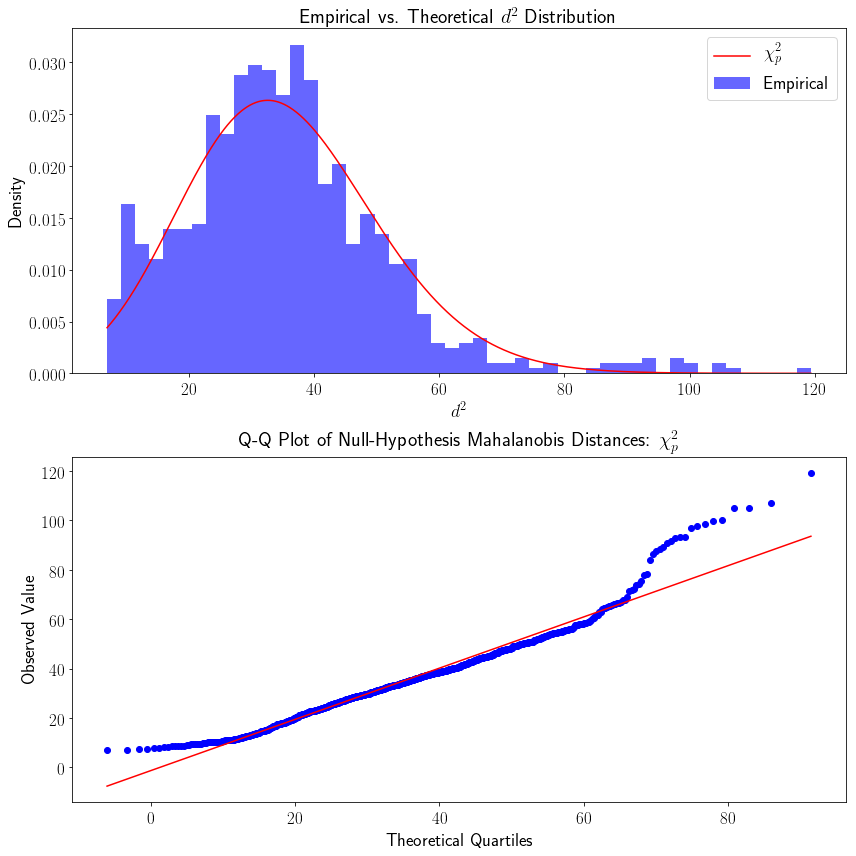

In [869]:
fig = plt.subplots(2,1, figsize=(12,12))

plt.subplot(2,1,1)
plt.hist(D2, 50, density=True, color='blue', alpha=0.6, label='Empirical')
plt.plot(xr, pdf_chi2_theory, color='red', label='$\chi^{2}_{p}$')
plt.title('Empirical vs. Theoretical $d^{2}$ Distribution', fontsize=20,fontweight='bold')
plt.xlabel('$d^{2}$', fontsize=18)
plt.xticks(fontsize=17, fontweight='bold')
plt.ylabel('Density', fontsize=18)
plt.yticks(fontsize=17, fontweight='bold')
plt.legend(fontsize=18)
plt.tight_layout()

plt.subplot(2,1,2)
probplot(D2.squeeze(), sparams=mle_chi2_theory, dist=chi2, plot=plt);
p_title = 'Q-Q Plot of Null-Hypothesis Mahalanobis Distances: $\chi^{2}_{p}$'
plt.title(p_title, fontsize=20, fontweight='bold')
ax.get_lines()[1].set_linestyle('--')

plt.xticks(fontsize=17, fontweight='bold')
plt.yticks(fontsize=17, fontweight='bold')
plt.xlabel('Theoretical Quartiles',fontsize=18)
plt.ylabel('Observed Value', fontsize=18)

plt.tight_layout()
plt.savefig('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/Density.QQPlot.png')


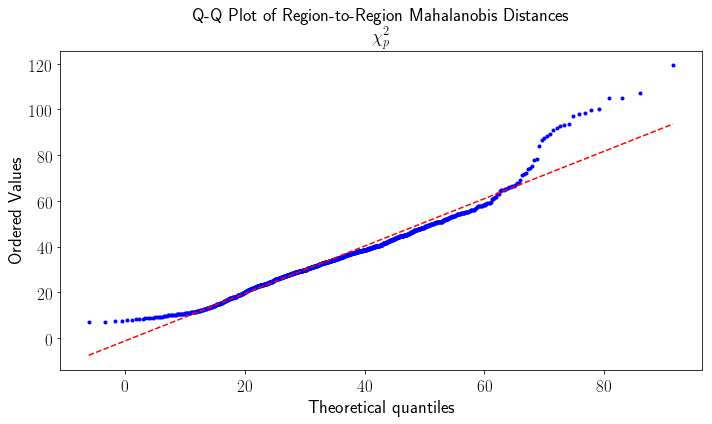

In [771]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

probplot(D2.squeeze(), sparams=mle_chi2_theory, dist=chi2, plot=plt);
p_title = 'Q-Q Plot of Region-to-Region Mahalanobis Distances \n $\chi^{2}_{p}$'
plt.title(p_title, fontsize=18)
ax.get_lines()[0].set_marker('.')

ax.get_lines()[1].set_linestyle('--')

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
plt.tight_layout()
plt.savefig('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/QQPlot.png')

/Users/kristianeschenburg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


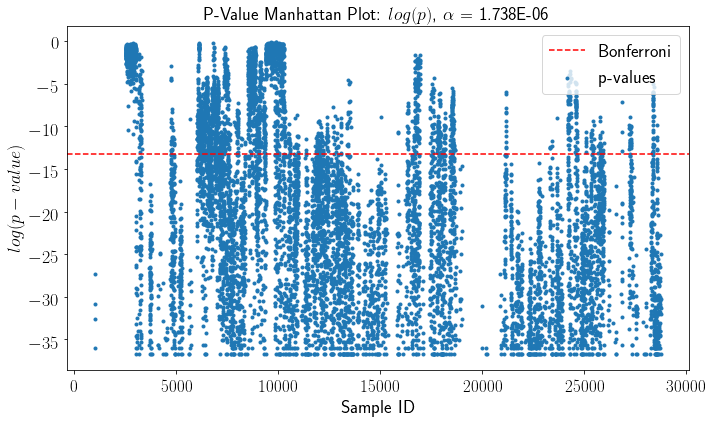

In [794]:
cdatas = 1-chi2.cdf(D1,*mle_chi2_theory)
passed = np.log(cdatas)

p_val = 0.05/D1.shape[0]

fig = plt.figure(figsize=(10, 6));
plt.scatter(np.arange(len(passed)), passed, marker='.', label='p-values');
plt.axhline(y=np.log(p_val), linestyle='--', color='red', label='Bonferroni');
plt.legend(fontsize=18);

plt.xlabel('Sample ID',fontsize=18);
plt.xticks(fontsize=17);
plt.ylabel('$log(p-value)$',fontsize=18);
plt.yticks(fontsize=18);
plt.title(r"P-Value Manhattan Plot: $log(p)$, $\alpha$ = %.3E" %(p_val), fontsize=18);
plt.tight_layout()
plt.savefig('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/PValues.png')

In [821]:
from scipy.misc import imread

In [851]:
region = imread('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/Region_LT.png')
mahals = imread('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/MahalanobisDistance.png')

/Users/kristianeschenburg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/Users/kristianeschenburg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


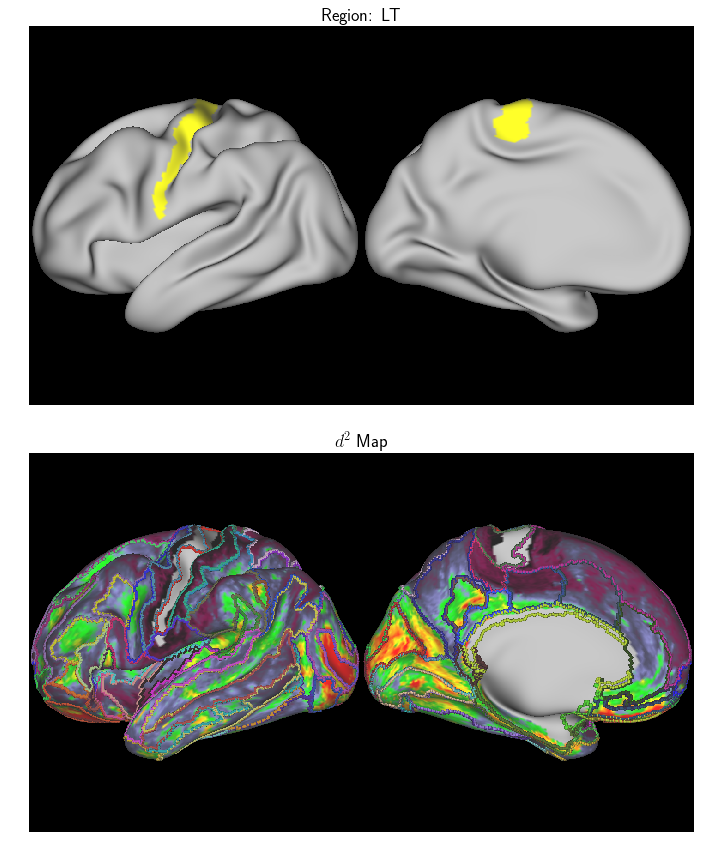

In [854]:
fig = plt.subplots(2,1,figsize=(12,12))
plt.subplot(2,1,1)
plt.imshow(region)
plt.axis('off')
plt.title('Region: LT', fontsize=18)

plt.subplot(2,1,2)
plt.imshow(mahals)
plt.axis('off')
plt.title('$d^{2}$ Map', fontsize=18)
plt.tight_layout()
plt.savefig('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/Maps.png')

In [881]:
cdata_inds = ~(cdatas>p_val)
passed_inds = non_g[cdata_inds]

passed_mahals = np.zeros((32492,))
passed_mahals[passed_inds] = D1[cdata_inds].squeeze()

In [882]:
write.save(passed_mahals,'/Users/kristianeschenburg/Desktop/Mahals.Passed.func.gii','CortexLeft')

In [951]:
sData = SN[label_map[5],:]
rData = RN[label_map[5],:]

In [952]:
sE = covariance.ShrunkCovariance(assume_centered=False,shrinkage=0.2)
sE.fit(sData)
sP = sE.precision_

rE = covariance.ShrunkCovariance(assume_centered=False,shrinkage=0.2)
rE.fit(rData)
rP = rE.precision_

In [953]:
r_2r = cdist(rData, rData.mean(0)[None,:],metric='mahalanobis',VI=rP)
r_2d = cdist(rData, sData.mean(0)[None,:],metric='mahalanobis',VI=sP)

d_2d = cdist(sData, sData.mean(0)[None,:],metric='mahalanobis',VI=sP)
d_2r = cdist(sData, rData.mean(0)[None,:],metric='mahalanobis',VI=rP)


In [954]:
R2R = r_2r**2
R2D = r_2d**2
D2R = d_2r**2
D2D = d_2d**2

In [8]:
mh_maps = []

EVs = {l: covariance.ShrunkCovariance(assume_centered=False, shrinkage=0.2) for l in labels}

for l in labels:
    EVs[l].fit(SN[label_map[l],:])

LT = 8
data_LT = SN[label_map[LT], :]
lt_to_brain = {}.fromkeys(labels)

for l in labels:
        
    temp_data = SN[label_map[l], :]
    temp_mu = temp_data.mean(0)[None, :]
    
    temp_mh = cdist(data_LT, temp_mu, metric='mahalanobis',VI=EVs[l].precision_)
    temp_mh2 = temp_mh**2
    
    lt_to_brain[l] = temp_mh2

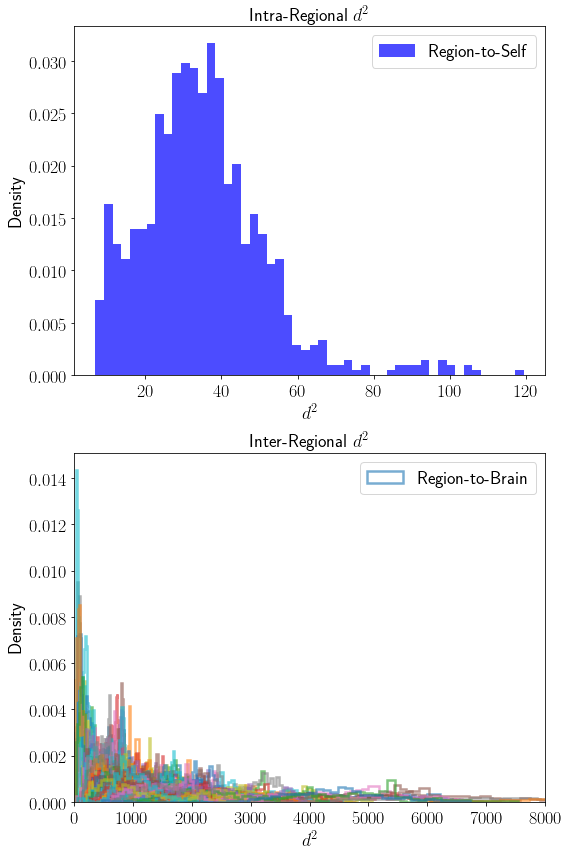

In [15]:
fig = plt.subplots(2,1, figsize=(12,12))
plt.subplot(2,1,1)
plt.hist(lt_to_brain[LT], 50, density=True, color='blue', label='Region-to-Self', alpha=0.7)
plt.legend(fontsize=18)
plt.xlabel('$d^{2}$', fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.yticks(fontsize=18)
plt.title('Intra-Regional $d^{2}$', fontsize=18)

plt.subplot(2,1,2)
for l in labels:
    if l != LT:
        plt.hist(lt_to_brain[l], 50, density=True, linewidth=2.5, alpha=0.6, histtype='step')
plt.xlim([0,8000])
plt.xlabel('$d^{2}$', fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.yticks(fontsize=18)
plt.title('Inter-Regional $d^{2}$', fontsize=18)

plt.legend(['Region-to-Brain'],fontsize=18)

plt.tight_layout()
plt.savefig('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/IntraInterMahal.jpg')

In [1]:
import scipy.io as sio

In [2]:
sio.savemat?

Signature: sio.savemat(file_name, mdict, appendmat=True, format='5', long_field_names=False, do_compression=False, oned_as='row')
Docstring:
Save a dictionary of names and arrays into a MATLAB-style .mat file.

This saves the array objects in the given dictionary to a MATLAB-
style .mat file.

Parameters
----------
file_name : str or file-like object
    Name of the .mat file (.mat extension not needed if ``appendmat ==
    True``).
    Can also pass open file_like object.
mdict : dict
    Dictionary from which to save matfile variables.
appendmat : bool, optional
    True (the default) to append the .mat extension to the end of the
    given filename, if not already present.
format : {'5', '4'}, string, optional
    '5' (the default) for MATLAB 5 and up (to 7.2),
    '4' for MATLAB 4 .mat files.
long_field_names : bool, optional
    False (the default) - maximum field name length in a structure is
    31 characters which is the documented maximum length.
    True - maximum field name 